In [1]:
from ovationpyme import ovation_prime
import numpy as np
import matplotlib.pyplot as plt
import datetime
from geospacepy import satplottools
#Copied from AMGeO core
def inverse_robinson(sigp,sigh,min_sigp=None,min_sigh=None):
    """Converts hall and pedersen conductance to mean energy and
    energy flux via Robinson formula

    Parameters
    ----------
    sigp : numpy.ndarray
        Pedersen conductance [S]
    sigh : numpy.ndarray
        Hall conductance [S]
    min_sigp : float,optional
        Pedersen conductance threshold, locations below which in
        sigp will be set to zero in energy flux / avg energy
        If None, no thresholding performed
    min_sigh : float,optional
        Hall conductance threshold, locations below which in
        sigh will be set to zero in energy flux / avg energy 
        If None, no thresholding performed

    Returns
    -------
    eavg : numpy.ndarray
        Average electron precipitation energy assuming maxwellian
        via Robinson empirical formula [keV]
    eflux : numpy.ndarray
        Total electron precipitation energy flux assuming maxwellian
        [mW/m^2] == [ergs/cm^2/s]
    """
    eavg = ((1/.45)*sigh/sigp)**(1/.85)
    eflux = (((16+eavg**2)/(40*eavg))*sigp)**2

    if min_sigp is not None:
        below_thresh_p = sigp<min_sigp
        eflux[below_thresh_p] = 0.
        eavg[below_thresh_p] = 0.
    elif min_sigh is not None:
        below_thresh_h = sigh<min_sigh
        eflux[below_thresh_h] = 0.
        eavg[below_thresh_h] = 0.

    return eavg,eflux

def robinson(eavg,eflux):
    sig_p = 40.*eavg/(16+eavg**2)*np.sqrt(eflux)
    sig_h = .45*eavg**0.85*sig_p
    return sig_p,sig_h

def draw_inverse_robinson_test():
    nconds = 20
    mincond = 1.
    peds = np.linspace(mincond,10,nconds)
    halls = np.linspace(mincond,20,nconds)
    ped_grid,hall_grid = np.meshgrid(peds,halls,indexing='ij')
    f_eflux = plt.figure(figsize=(8,8))
    f_eavg = plt.figure(figsize=(8,8))
    a_eflux,a_eavg = f_eflux.add_subplot(111),f_eavg.add_subplot(111)
    
    eavg,eflux = inverse_robinson(ped_grid,
                               hall_grid,
                               min_sigp=mincond,
                               min_sigh=mincond)
    
    mappable_eflux = a_eflux.pcolor(ped_grid,hall_grid,eflux)
    mappable_eavg = a_eavg.pcolor(ped_grid,hall_grid,eavg)
    
    f_eflux.colorbar(mappable_eflux,label='Electron Energy Flux [mW/m^2]')
    f_eavg.colorbar(mappable_eavg,label='Electron Average Energy [keV]')
    
    sig_p,sig_h = robinson(eavg,eflux)
    print('Pederesen',sig_p[:,0].flatten())
    print('Hall',sig_h[0,:].flatten())
    
    
    plt.show()
    
def draw_min_max(ax,x):
    ax.text(-40.,-50,
    'Min: %.1f \nMax: %.1f' % (np.nanmin(x.flatten()),
                            np.nanmax(x.flatten())))
    

#Copied from ovationpyme.functionaltests
def draw_conductance(dt,hemi,estimator):
    """
    Get the hall and pedersen conductance for one date and hemisphere
    """
    import time
    
    t0nc = time.time()
    mlatgrid,mltgrid,pedgrid_nocorr,hallgrid_nocorr = estimator.get_conductance(dt,hemi=hemi,auroral=True,solar=False,
                                                                    interp_bad_bins=False)
    t1nc = time.time()
    dtnc = t1nc-t0nc
    
    t0c = time.time()
    mlatgrid,mltgrid,pedgrid,hallgrid,dF = estimator.get_conductance(dt,hemi=hemi,auroral=True,solar=False,
                                                                    interp_bad_bins=True,return_dF=True)
    t1c = time.time()
    dtc = t1c-t0c
    
    print('get_conductance takes %f without correction, %f with correction' % (dtnc,dtc))
    eavg,eflux = inverse_robinson(pedgrid,
                                   hallgrid,
                                   min_sigp=.1,
                                   min_sigh=.1)

    f = plt.figure(figsize=(11,15))
    aHnc = f.add_subplot(321)
    aPnc = f.add_subplot(322)
    aH = f.add_subplot(323)
    aP = f.add_subplot(324)
    aEF = f.add_subplot(325)
    aEA = f.add_subplot(326)

    X,Y = satplottools.latlt2cart(mlatgrid.flatten(),mltgrid.flatten(),hemi)
    X = X.reshape(mlatgrid.shape)
    Y = Y.reshape(mltgrid.shape)

    satplottools.draw_dialplot(aHnc)
    satplottools.draw_dialplot(aPnc)
    satplottools.draw_dialplot(aH)
    satplottools.draw_dialplot(aP)
    satplottools.draw_dialplot(aEF)
    satplottools.draw_dialplot(aEA)

    mappableHnc = aHnc.pcolormesh(X,Y,hallgrid_nocorr,vmin=0.,vmax=20.)
    mappablePnc = aPnc.pcolormesh(X,Y,pedgrid_nocorr,vmin=0.,vmax=15.)
    mappableH = aH.pcolormesh(X,Y,hallgrid,vmin=0.,vmax=20.)
    mappableP = aP.pcolormesh(X,Y,pedgrid,vmin=0.,vmax=15.)
    mappableEF = aEF.pcolormesh(X,Y,eflux,cmap='viridis',vmax=4)
    mappableEA = aEA.pcolormesh(X,Y,eavg,cmap='viridis',vmax=4)
    
    draw_min_max(aHnc,hallgrid_nocorr)
    draw_min_max(aPnc,pedgrid_nocorr)
    draw_min_max(aH,hallgrid)
    draw_min_max(aP,pedgrid)
    draw_min_max(aEF,eflux)
    draw_min_max(aEA,eavg)
    
    
    aHnc.set_title("Hall Conductance (Uncorrected)")
    aPnc.set_title("Pedersen Conductance (Uncorrected)")
    aH.set_title("Hall Conductance")
    aP.set_title("Pedersen Conductance")
    aEF.set_title('Inverse Robinson EFlux')
    aEA.set_title('Inverse Robinson EAvg')
    
    
    f.colorbar(mappableHnc,ax=aHnc)
    f.colorbar(mappablePnc,ax=aPnc)
    f.colorbar(mappableH,ax=aH)
    f.colorbar(mappableP,ax=aP)
    f.colorbar(mappableEF,ax=aEF)
    f.colorbar(mappableEA,ax=aEA)

    f.suptitle("OvationPyme Conductance Output \n %s Hemisphere at %s \n Coupling=%f" % (hemi,dt.strftime('%c'),dF),
        fontweight='bold')
    plt.show()
    return f

def draw_numflux(estimator,dt,hemi='N'):
    from matplotlib.colors import LogNorm
    
    f = plt.figure(figsize=(11,5))
    
    ax_eflux = f.add_subplot(121)
    ax_eavg = f.add_subplot(122)
    
    satplottools.draw_dialplot(ax_eflux)
    satplottools.draw_dialplot(ax_eavg)
    
    mlatgrid,mltgrid,diff_numflux = estimator.numflux_estimator['diff'].get_flux_for_time(dt,hemi=hemi)
    mlatgird,mltgrid,diff_eavg = estimator.eavg_estimator['diff'].get_flux_for_time(dt,hemi=hemi)
    
    X,Y = satplottools.latlt2cart(mlatgrid.flatten(),mltgrid.flatten(),hemi)
    X = X.reshape(mlatgrid.shape)
    Y = Y.reshape(mltgrid.shape)

    diff_eflux = diff_numflux*1.6022e-9*diff_eavg #keV to ergs, * #/(cm^2 s)
    #norm=LogNorm(vmin=.01, vmax=np.nanpercentile(diff_eflux,97.))
    
    mappable_eflux = ax_eflux.pcolormesh(X,Y,diff_eflux,vmin=0,vmax=4)
    mappable_eavg = ax_eavg.pcolormesh(X,Y,diff_eavg,vmin=0,vmax=4)
    
    ax_eflux.set_title("OP2010 Eflx (Diffuse)")
    ax_eavg.set_title("OP2010 Eavg (Diffuse)")
    
    draw_min_max(ax_eflux,diff_eflux)
    draw_min_max(ax_eavg,diff_eavg)
    
    f.colorbar(mappable_eflux,ax=ax_eflux,label='[mW/m^2]')
    f.colorbar(mappable_eavg,ax=ax_eavg,label='[keV]')
    plt.show()
    return f

startdt = datetime.datetime(2017,9,7)
enddt = datetime.datetime(2017,9,9)

estimator = ovation_prime.ConductanceEstimator(startdt,enddt,fluxtypes=['diff','mono'])


Populating the interactive namespace from numpy and matplotlib


/home/liamk/mirror/Projects/davitpy_latest/ovationpyme/ovationpyme/ovation_utilities.py:70: RuntimeWarning: invalid value encountered in less
  neg_tc = BT*np.cos(tc)*Bz < 0


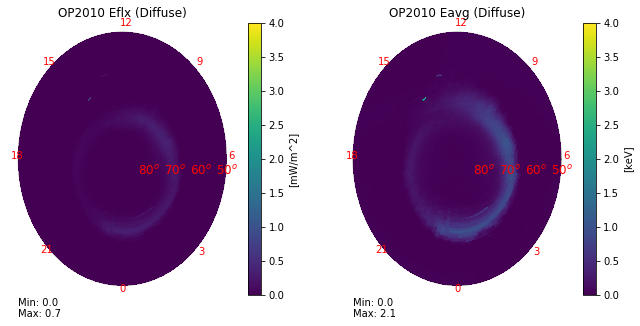

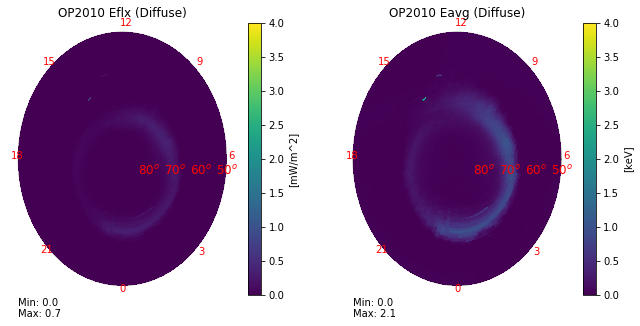

In [2]:
#draw_inverse_robinson_test()
%pylab inline
dt = datetime.datetime(2016,11,13,2,25)
draw_numflux(estimator,dt)

Populating the interactive namespace from numpy and matplotlib


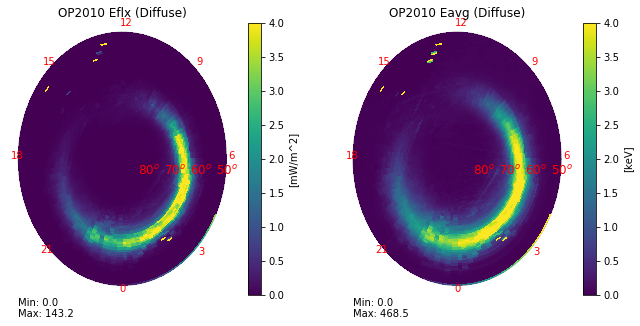

Getting conductance with solar False, aurora True, fluxtypes ['diff'], background_ped: None, background_hall None
Getting conductance with solar False, aurora True, fluxtypes ['diff'], background_ped: None, background_hall None
get_conductance takes 0.763113 without correction, 1.745780 with correction


/home/liamk/anaconda2/envs/davitpy_latest/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide


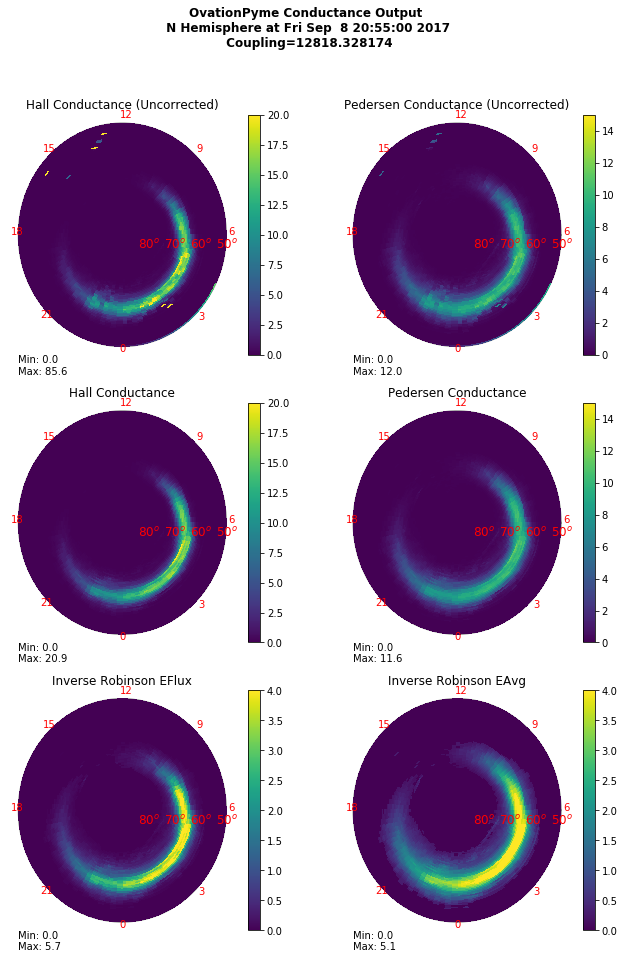

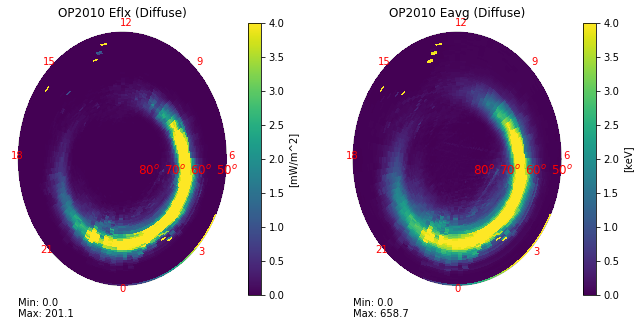

Getting conductance with solar False, aurora True, fluxtypes ['diff'], background_ped: None, background_hall None
Getting conductance with solar False, aurora True, fluxtypes ['diff'], background_ped: None, background_hall None
get_conductance takes 0.744599 without correction, 1.722633 with correction


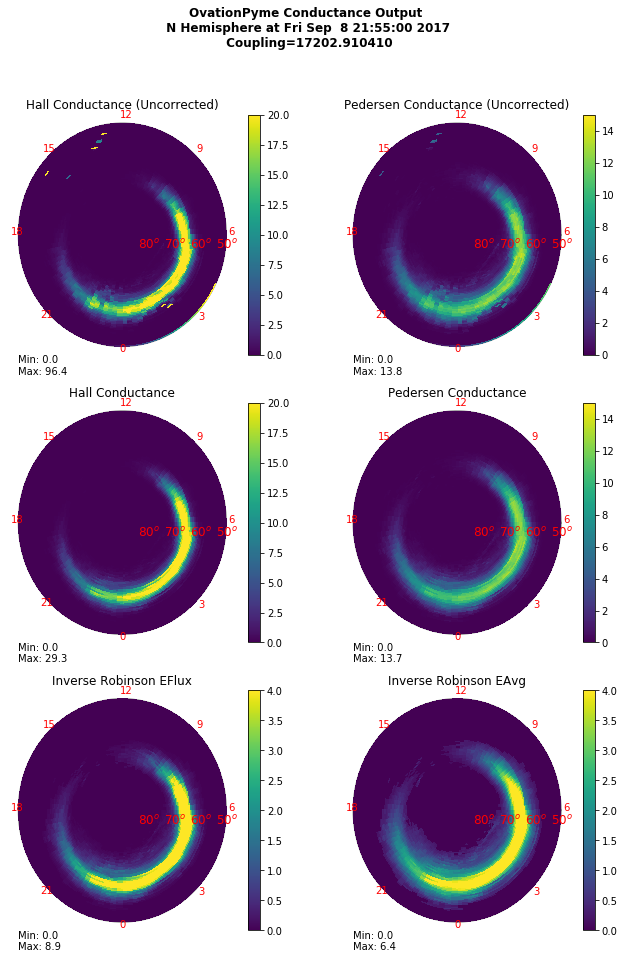

In [4]:
%pylab inline
dt1 = datetime.datetime(2017,9,8,20,55)
dt2 = datetime.datetime(2017,9,8,21,55)

draw_numflux(estimator,dt1)
f1 = draw_conductance(dt1,'N',estimator)
f1.savefig('/home/liamk/Desktop/ovation_fix_test_%s.png' % (dt1.strftime('%c')))

draw_numflux(estimator,dt2)
f2 = draw_conductance(dt2,'N',estimator)
f2.savefig('/home/liamk/Desktop/ovation_fix_test_%s.png' % (dt2.strftime('%c')))

plt.show()